# Fitness assay simulations

In this project, I explore the limitations of inferring fitness effects and gene essentiality from bulk fitness assays such as deep mutational scans, CRISPR screens, transposon sequencing approaches. These experiments involve engineering a large number of mutations/variants, pooling them, and tracking frequencies of a variants pool (or library) using sequencing as a readout. 

While the increased throughput is great, there is potential for systematic bias in measurements (see Li et al, Cell Systems). Further, different biological questions address different magnitude of fitness effects, which are known to have different measurement errors. 

Here, I simulate fitness assays to explore how assay design can be tuned for the specific fitness effects of interest; particularly, I compare fitness effects near neutrality (often of interest in experimental evolution, yeast GWAS type studies), and deleterious effects (more the focus of functional genomic screens)

### Definitions/Terminology

- Neutral mutation: a mutation which has no impact on cellular growth.
- Deleterious mutation: mutation leading to a reduction in growth rate. Note that deleterious effects lie in a continuum between essentiality (or inviability) and neutrality.
- Fitness: the per-generation log-fold change in frequency of a mutant.

In [1]:
#importing libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
import pandas as pd
import seaborn as sns
import pathlib
import os

In [2]:
sns.set_theme()
sns.set_context('paper')

#### Importing functions for reanalysis of data + additional helper functions

In [3]:
from functions import *

### Exploring errors in simulated data

Approach:

- for every fitness effect, simulate trajectories for 5 replicates, changing sequencing depth, number of generations per day and number of days
- for every simulation, calculate fitnesses and estimate the standard error of the measurement

In [19]:
n_generations = np.linspace(5,20,4)
n_days = np.linspace(2,5,4)
seq_depth = np.array([20,50,100])

### Sanity check: 

Simulate different fitness effects, and estimate fitness effects from the counts.

In [4]:
trajs = simulate_assay(initial_counts=np.ones(1000)*100, s_mut=0, t=2, gens=10)

In [5]:
fitness_calculator_replicates(trajs, 10, 5)

(-0.0010168855333515493, 0.004264511530625387)

Input fitness and output fitness are consistent; we're good to go.

### Fig 1: Uncertainty in error as a function of true fitness

a) Theoretical bounds (assumes Poisson noise)

Will include formula later. But for now, refer to the paper

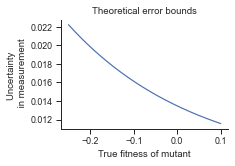

In [6]:
coverage, t_rec, t_fa = 500, 0, np.log2(100)
s_range = np.linspace(-0.25, 0.1, 200)
upper, lower = bounds_estimator(coverage=coverage, t_library=0, t_recovery=t_rec, t_assay=t_fa,fitness_range=s_range)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,1,figsize=(3,2))
    ax.plot(s_range, (upper-lower)/2)
    ax.set(xlabel='True fitness of mutant', ylabel='Uncertainty \n in measurement', title='Theoretical error bounds')
    sns.despine()
    plt.show()

b) Simulated data

In [7]:
error = []
for s in np.linspace(-0.25, 0.1, 100):
    trajs = simulate_assay(initial_counts=np.ones(5000)*100, s_mut=s, t=2, gens=np.log2(100))
    mean, std = fitness_calculator_replicates(trajs, np.log2(100), 5)
    error.append(std)

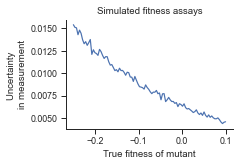

In [8]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,1, figsize=(3,2))
    ax.plot(np.linspace(-0.25, 0.1, 100), error)
    ax.set_xlabel('True fitness of mutant')
    ax.set_ylabel('Uncertainty \nin measurement')
    ax.set(xlabel='True fitness of mutant', ylabel='Uncertainty \nin measurement', title='Simulated fitness assays')
    sns.despine()
    plt.show()
#     fig.savefig('./Figures/'+'measurement_uncertainty_simulations.pdf', format='pdf', bbox_inches='tight')

Combining both panels into one output file, so I don't have to deal with font/formatting consistency.

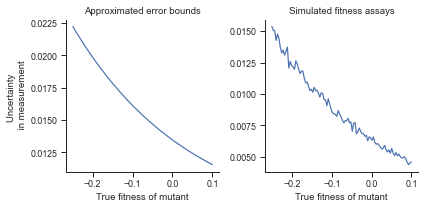

In [9]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=False)
    ax[0].plot(s_range, (upper-lower)/2)
    ax[0].set(xlabel='True fitness of mutant', ylabel='Uncertainty \n in measurement', title='Approximated error bounds')
    ax[0].locator_params(axis='y', nbins=5)
    ax[1].plot(np.linspace(-0.25, 0.1, 100), error)
    ax[1].locator_params(axis='y', nbins=5)

    ax[1].set(xlabel='True fitness of mutant', title='Simulated fitness assays')
    fig.tight_layout()
    sns.despine()
#     fig.savefig('./Figures/measurement_uncertainty.pdf', format='pdf', bbox_inches='tight')


### Fig 2: how does error in fitness estimates depend on experimental parameters such as sequencing depth, number of bottlenecks, and number of generations per day?

a) Varying sequencing depth

In [10]:
error_depth = []
for depth in np.linspace(10,200,50):
    trajs = simulate_assay(initial_counts=np.ones(5000)*depth, s_mut=0, t=2, gens=np.log2(100))
    mean, std = fitness_calculator_replicates(trajs, np.log2(100), 5)
    error_depth.append(std)

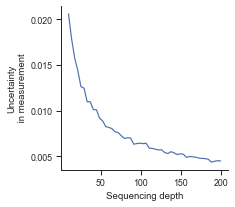

In [11]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    ax.plot(np.linspace(10,200,50), error_depth)
    ax.set_xlabel('Sequencing depth')
    ax.locator_params(axis='y', nbins=5)
    ax.set_ylabel('Uncertainty\n in measurement')
    sns.despine()
    plt.show()
#     fig.savefig('./Figures/neutral_muts_a.pdf', format='pdf', bbox_inches='tight')

b) Varying number of bottlenecks

In [12]:
error_bot = []
for time in np.linspace(2,6,5):
    trajs = simulate_assay(initial_counts=np.ones(5000)*100, s_mut=0, t=time.astype('int'), gens=np.log2(100))
    mean, std = fitness_calculator_replicates(trajs, np.log2(100), 5)
    error_bot.append(std)

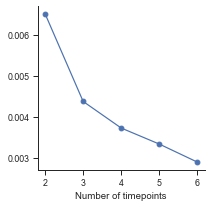

In [13]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    ax.plot(np.linspace(2,6,5), error_bot, '-o')
    ax.locator_params(axis='y', nbins=5)

    ax.set_xlabel('Number of timepoints')
    plt.xticks(np.linspace(2,6,5))
    sns.despine()
    plt.show()
#     fig.savefig('./Figures/neutral_muts_b.pdf', format='pdf', bbox_inches='tight')

a,b) Combining the two plots above into a single output file.

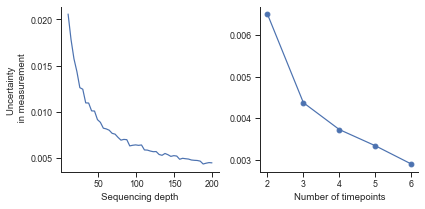

In [14]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=False)
    ax[0].plot(np.linspace(10,200,50), error_depth)
    ax[0].locator_params(axis='y', nbins=5)
    ax[0].set(xlabel='Sequencing depth', ylabel='Uncertainty \n in measurement')
    ax[1].plot(np.linspace(2,6,5), error_bot, '-o')
    ax[1].set(xlabel='Number of timepoints')
    ax[1].locator_params(axis='y', nbins=5)

    fig.tight_layout()
    sns.despine()
#     fig.savefig('./Figures/neutral_muts_ab.pdf', format='pdf', bbox_inches='tight')


Two dimensional plots of number of days vs sequencing. This one is important because it may be useful to know if it's better to have more days or more depth per day for fixed number of reads

In [15]:
depth_days = np.zeros([50,5])
seq_depth = np.linspace(10,200,50)
days_range = np.linspace(2,6,5).astype('int')

In [16]:
for i in range(len(seq_depth)):
    for j in range(len(days_range)):
        trajs = simulate_assay(initial_counts=np.ones(10000)*seq_depth[i], s_mut=0, t=days_range[j], gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_days[i,j] = std

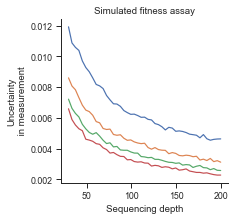

In [17]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    for i in range(len(days_range)-1):
        ax.plot(seq_depth[5:], depth_days[5:, i], label=f'{days_range[i]} timepoints')
        ax.set_xlabel('Sequencing depth')
        ax.set_ylabel('Uncertainty\n in measurement')
        ax.set_title('Simulated fitness assay')
#     ax.legend(loc=0)
    sns.despine()
#     plt.title(f's={0}')
    plt.show()
#     fig.savefig('./Figures/neutral_muts_c.pdf', format='pdf', bbox_inches='tight')

#### Repeating the above simulation but including an additional 1/N factor for sampling noise during a bottleneck

Does including the bottleneck size make the error flatten out? Turns out to depend on the bottleneck size: if it is ~200 (like in our TnSeq experiments), then it doesn't contribute much noise, but if it's ~50, then it is more of a factor.

In [18]:
depth_days_bot = np.zeros([50,5])
bottleneck = 200
for i in range(len(seq_depth)):
    for j in range(len(days_range)):
        sample_depth = 1/(1/bottleneck+1/seq_depth[i])
        trajs = simulate_assay(initial_counts=np.ones(10000)*sample_depth, s_mut=0, t=days_range[j], gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_days_bot[i,j] = std


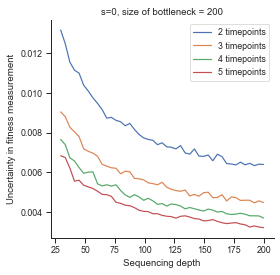

In [19]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    for i in range(len(days_range)-1):
        plt.plot(seq_depth[5:], depth_days_bot[5:, i], label=f'{days_range[i]} timepoints')
        plt.xlabel('Sequencing depth')
        plt.ylabel('Uncertainty in fitness measurement')
    plt.legend(loc=0)
    sns.despine()
    plt.title(f's={0}, size of bottleneck = {bottleneck}')
    plt.show()

### Fig 3: how does error in estimates for deleterious mutations depend on experimental parameters?

a) error vs sequencing depth for range of deleterious fitness effects 

In [20]:
depth_fitness = np.zeros([50,6])
s_range = np.linspace(-0.3,0,4)

In [21]:
for i in range(len(seq_depth)):
    for j in range(len(s_range)):
#         sample_depth=1/(1/bottleneck+1/seq_depth[i])
        trajs = simulate_assay(initial_counts=np.ones(5000)*seq_depth[i], s_mut=s_range[j], t=2, gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_fitness[i,j] = std

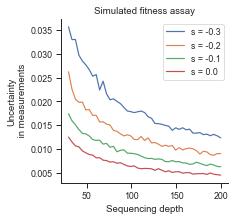

In [22]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    for i in range(len(s_range)):
        ax.plot(np.linspace(10,200,50)[5:], depth_fitness[5:, i], label=f's = {np.round(s_range[i],2)}')
        ax.set_xlabel('Sequencing depth')
        ax.set_ylabel('Uncertainty\n in measurements')
    ax.set_title('Simulated fitness assay')
    plt.legend(loc=0)
    sns.despine()
    plt.show()
#     fig.savefig('./Figures/deleterious_muts_a.pdf', format='pdf', bbox_inches='tight')

b) Using theoretical bounds to calculate error in fitness estimates for different number of bottlenecks.

In [23]:
n_generations = np.linspace(1,4,4)*np.log2(100)
error_gens = np.zeros([len(n_generations),len(s_range)])

In [24]:
for i in range(len(n_generations)):
    gens = n_generations[i]
    for j in range(len(s_range)):
        s = s_range[j]
        upper,lower = bounds_estimator(coverage=500, t_library=0, t_recovery=0, t_assay=gens, fitness_range=s)
        error_gens[i,j] = (upper-lower)/2

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays/AnalysisNotebooks/functions.py:241: RuntimeWarning: invalid value encountered in log
  lower = np.log((coverage_site_t1 - coverage_site_t1**0.5)/((coverage_site_t0 + coverage_site_t0**0.5)))/t_assay


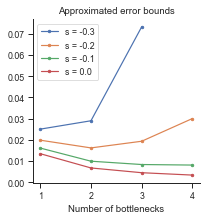

In [25]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    for j in range(len(s_range)):
        ax.plot(np.linspace(1,4,4), error_gens[:,j], '.-', label='s = '+str(np.round(s_range[j],2)))
        
    ax.set_xlabel('Number of bottlenecks')
    ax.set_title('Approximated error bounds')
#     ax.set_ylabel('Error bounds (upper-lower)')
    plt.legend(loc=0)
    # plt.yscale('log')
    # plt.ylim(0, 0.1)
    sns.despine()
#     fig.savefig('./Figures/deleterious_theoretical_bounds.pdf', format='pdf', bbox_inches='tight')

c,d) For a deleterious mutation, how does the measurement error depend on the number of bottlenecks and the sequencing depth?

First with a deleterious fitness effect of -0.15

In [26]:
depth_days_del1 = np.zeros([50,5])
for i in range(len(seq_depth)):
    for j in range(len(days_range)):
        trajs = simulate_assay(initial_counts=np.ones(10000)*seq_depth[i], s_mut=-0.15, t=days_range[j], gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_days_del1[i,j] = std

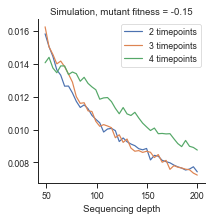

In [27]:
with sns.axes_style('ticks'):
    
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    for i in range(len(days_range)-2):
        ax.plot(seq_depth[10:], depth_days_del1[10:, i], label=f'{days_range[i]} timepoints')
    ax.set_xlabel('Sequencing depth')
    plt.legend(loc=0)
    sns.despine()
    plt.title(f'Simulation, mutant fitness = {-0.15}')
    plt.show()
#     fig.savefig('./Figures/deleterious_muts_d.pdf', format='pdf', bbox_inches='tight')

Next, with a deleterious effect of -0.1

In [28]:
depth_days_del2 = np.zeros([50,5])
for i in range(len(seq_depth)):
    for j in range(len(days_range)):
        trajs = simulate_assay(initial_counts=np.ones(10000)*seq_depth[i], s_mut=-0.1, t=days_range[j], gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_days_del2[i,j] = std


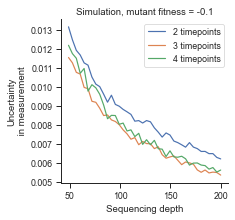

In [29]:
with sns.axes_style('ticks'):
    
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    for i in range(len(days_range)-2):
        ax.plot(seq_depth[10:], depth_days_del2[10:, i], label=f'{days_range[i]} timepoints')
    ax.set_xlabel('Sequencing depth')
    ax.set_ylabel('Uncertainty\n in measurement')
    plt.legend(loc=0)
    sns.despine()
    plt.title(f'Simulation, mutant fitness = {-0.1}')
    plt.show()
#     fig.savefig('./Figures/deleterious_muts_c.pdf', format='pdf', bbox_inches='tight')

### Figure 4: How much usable information do we get with multiple timepoints for deleterious mutations?

What fraction of mutations survive after a given number of bottlenecks?
Simulate 1000 mutations (with 5 replicates each) and count for how many mutations, at least two replicates survive.

We're also only extracting data for the number of uncalculated mutants and the mean fitness whenever it is calculated.

In [30]:
s_range = np.linspace(-0.3, -0.15, 4)
uncalc_data = np.zeros([len(seq_depth), len(days_range)-1, len(s_range)])
mean_data = np.zeros([len(seq_depth), len(days_range)-1, len(s_range)])
reps_data = np.zeros([len(seq_depth), len(days_range)-1, len(s_range)])
for k in range(len(s_range)): #first iterate over different deleterious mutations
    s = s_range[k]
    for i in range(len(seq_depth)):
        for j in range(len(days_range)-1):
            trajs = simulate_assay(initial_counts=np.ones(5000)*seq_depth[i], s_mut=s, t=days_range[j], gens=np.log2(100))
            mean, std, uncalc, reps_used = fitness_calculator_replicates(trajs, np.log2(100), reps=5, uncalculated_count=True)
            uncalc_data[i,j,k] = uncalc
            mean_data[i,j,k] = mean
            reps_data[i,j,k] = np.mean(reps_used)

/Users/anuraglimdi/opt/miniconda3/envs/sns_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anuraglimdi/opt/miniconda3/envs/sns_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


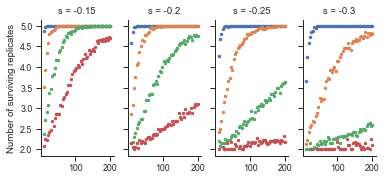

In [31]:
with sns.axes_style('ticks'):
    fig,axes = plt.subplots(1,4,figsize=(6,2.5), sharex=True, sharey=True)
    # Iterate over the axes
    for i, ax in enumerate(axes.flatten()):
        data_plot = reps_data[:,:,3-i]
        for j in range(len(days_range)-1):
            ax.plot(np.linspace(10,200,50), data_plot[:,j], '.')
        ax.set(title = f's = {s_range[3-i]}')
        if i==0:
            ax.set_ylabel('Number of surviving replicates')
    sns.despine()
#     fig.savefig('./Figures/number_trajs_deleterious_muts.pdf', format='pdf', bbox_inches='tight')
    plt.show()


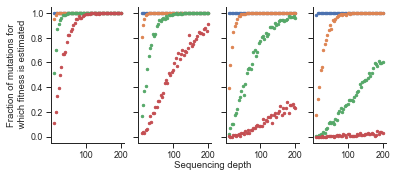

In [32]:
with sns.axes_style('ticks'):
    fig,axes = plt.subplots(1,4,figsize=(6,2.5), sharex=True, sharey=True)
    # Iterate over the axes
    for i, ax in enumerate(axes.flatten()):
        data_plot = uncalc_data[:,:,3-i]
        for j in range(len(days_range)-1):
            ax.plot(np.linspace(10,200,50), (1000-data_plot[:,j])/1000, '.')
        if i==0:
            ax.set_ylabel('Fraction of mutations for\n which fitness is estimated')
    # Set common labels
    fig.text(0.5, 0.00, 'Sequencing depth', ha='center', va='center')


    sns.despine()
#     fig.savefig('./Figures/calculated_mutants.pdf', format='pdf', bbox_inches='tight')
    plt.show()


### Figure 5: Resolving deleterious mutations

For experimental parameters where trajectories are starting to disappear, can we make use of the remaining surviving trajectories to extract useful info about mutant fitness?

To address this, we compare the fitness estimate obtained from simulated fitness assays, and compare them to the "true" fitness of a mutation

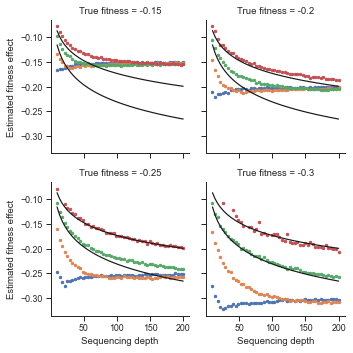

In [33]:
depth_range = np.linspace(10,200,50)
with sns.axes_style('ticks'):
    fig,axes = plt.subplots(2,2,figsize=(5,5), sharex=True, sharey=True)
    # Iterate over the axes
    for i, ax in enumerate(axes.flatten()):
        data_plot = mean_data[:,:,3-i]
        for j in range(len(days_range)-1):
            ax.plot(depth_range, (data_plot[:,j]), '.', label=f'{days_range[j]-1} Bottlenecks')
            if j in [2,3]:
                ax.plot(depth_range, np.log(1/depth_range)/(days_range[j]-1)/np.log2(100), 'k')
        ax.set(title = f'True fitness = {s_range[3-i]}')
        if i in [0,2]:
            ax.set_ylabel('Estimated fitness effect')
        if i in [2,3]:
            ax.set_xlabel('Sequencing depth')
#             if i==3:
#                 ax.legend(loc=0)
    fig.tight_layout()    
    sns.despine()

While this figure above looks very cool, I'm going to only use the bottom two subpanels, and construct them individually.

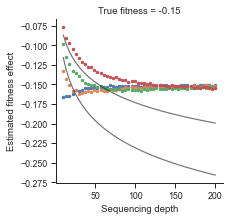

In [34]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    data_plot = mean_data[:,:,3]
    for j in range(len(days_range)-1):
        ax.plot(depth_range, (data_plot[:,j]), '.', label=f'{days_range[j]-1} Bottlenecks')
        if j>1:# don't plot the theoretical bound for the two bottleneck scenario:
            ax.plot(depth_range, np.log(1/depth_range)/(days_range[j]-1)/np.log2(100), 'k', alpha=0.6)
    ax.set(title=f'True fitness = {s_range[3]}', ylabel='Estimated fitness effect', xlabel='Sequencing depth')
#     ax.plot(depth_range, np.ones(len(depth_range))*s_range[1], color='k')
    sns.despine()
#     fig.savefig('./Figures/resolving_deleterious_muts_a.pdf', format='pdf', bbox_inches='tight')

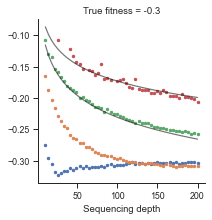

In [35]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    data_plot = mean_data[:,:,0]
    for j in range(len(days_range)-1):
        ax.plot(depth_range, (data_plot[:,j]), '.', label=f'{days_range[j]-1} Bottlenecks')
        if j>1:# don't plot the theoretical bound for the two bottleneck scenario:
            ax.plot(depth_range, np.log(1/depth_range)/(days_range[j]-1)/np.log2(100), 'k', alpha=0.6)
    ax.set(title=f'True fitness = {s_range[0]}', xlabel='Sequencing depth')
#     ax.plot(depth_range, np.ones(len(depth_range))*s_range[1], color='k')
    sns.despine()
#     fig.savefig('./Figures/resolving_deleterious_muts_b.pdf', format='pdf', bbox_inches='tight')

theoretical lower bound estimate for different experimental parameters

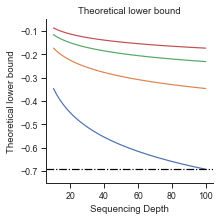

In [36]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    for i in range(0,len(days_range)-1):
        ax.plot(np.linspace(10,100,50), np.log(1/np.linspace(10,100,50))/(days_range[i]-1)/np.log2(100))
    ax.axhline(-np.log(2), color='black', label='Fitness of \nunviable strain', linestyle='-.')
    ax.set(xlabel='Sequencing Depth', ylabel='Theoretical lower bound', ylim=(-0.75, -0.05),
          title='Theoretical lower bound')
#     ax.legend(loc=0)
    sns.despine()
#     fig.savefig('./Figures/theoretical_lower_bound.pdf', format='pdf', bbox_inches='tight')

Extracting legend only. Many plots don't have enough space for a legend, so I'm extracting the legend as a separate file and will add to Figures 4 and 5

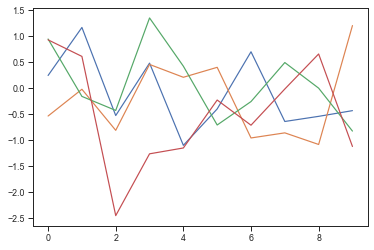

<Figure size 144x144 with 0 Axes>

In [37]:
import pylab

with sns.axes_style('ticks'):
    fig = pylab.figure()
    figlegend = pylab.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10),range(10), pylab.randn(10), range(10), pylab.randn(10))
    figlegend.legend(lines, ('2 timepoints', '3 timepoints', '4 timepoints', '5 timepoints'), 'center', ncol=4)
    # fig.show()
    # figlegend.show()
#     figlegend.savefig('./Figures/legend.pdf', format='pdf', bbox_inches='tight')


### Figure 5+: More replicates or more depth per replicate.

`Probably skipping this analysis for the paper` 

it is a digression from the more important point of differences in fitness assay design for different ranges of fitness effects.

- For a fixed sequencing depth, there is a tradeoff between measuring many mutants with lower precision, and fewer mutations with very high precision. Here, I'll do some quick estimates on how the error varies with number of replicates, while also changing the total reads and fitness of the mutation.

In [1009]:
total_reads = 10**2
replicate_range = np.linspace(2,25,24)

In [1010]:
error = []
#first a neutral mutation
for rep in replicate_range:
    coverage1 = total_reads/rep
    error.append(1/6.64/np.sqrt(rep)*np.log((coverage1+np.sqrt(coverage1))/(coverage1-np.sqrt(coverage1))))

In [1011]:
error1 = []
error2 = []
s = -0.3
#now a deleterious mutation
for rep in replicate_range:
    coverage1 = total_reads/rep
    coverage2 = coverage1*np.exp(s*6.64)
    upper_bound = 1/6.64*np.log((coverage2+np.sqrt(coverage2))/(coverage1-np.sqrt(coverage1)))
    lower_bound = 1/6.64*np.log((coverage2-np.sqrt(coverage2))/(coverage1+np.sqrt(coverage1)))
    error1.append(1/np.sqrt(rep-1)*(upper_bound-s))
    error2.append(1/np.sqrt(rep-1)*(lower_bound-s))


<ipython-input-1011-b04fc257ede6>:9: RuntimeWarning: invalid value encountered in log
  lower_bound = 1/6.64*np.log((coverage2-np.sqrt(coverage2))/(coverage1+np.sqrt(coverage1)))


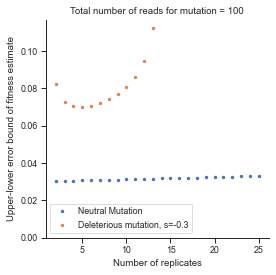

In [1012]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    plt.plot(replicate_range, error, '.', label='Neutral Mutation')
    plt.plot(replicate_range, (np.abs(error2)+np.array(error1))/2, '.', label=f'Deleterious mutation, s={s}')
    plt.legend(loc=0)
    plt.xlabel('Number of replicates')
    plt.ylabel('Upper-lower error bound of fitness estimate')
    plt.title(f'Total number of reads for mutation = {total_reads}')
    plt.ylim(0)
    sns.despine()

### Miscellaneous stuff

Not currently in the paper, but don't want to trash this analysis yet. 

In [917]:
days_range

array([2, 3, 4, 5, 6])

In [45]:
n_generations = np.array([6,8,10,12,15,20])
s_range = np.linspace(-np.log(2), -0.1, 100)
coverage = np.array([10,20,50,100,200])

In [46]:
def dropout_probability(fitness, generations, depth):
    expected_counts = depth*np.exp(fitness*generations)
    return np.exp(-expected_counts) #p(0) = e^(-lambda)

In [47]:
prob_gens = [dropout_probability(s_range, gens, depth=25) for gens in n_generations]

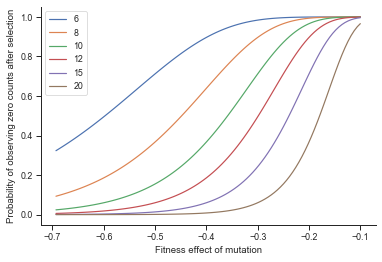

In [48]:
with sns.axes_style('ticks'):
    plt.plot(s_range, 1-np.transpose(prob_gens), label = n_generations)
    plt.legend()
    plt.xlabel('Fitness effect of mutation')
    plt.ylabel('Probability of observing zero counts after selection')
    sns.despine()

In [49]:
prob_coverage = [dropout_probability(s_range, generations=10, depth=depth) for depth in coverage]

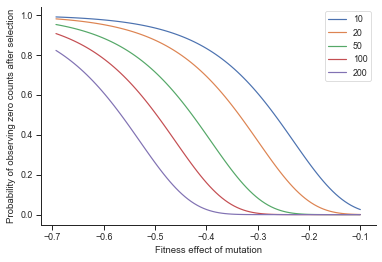

In [50]:
with sns.axes_style('ticks'):
    plt.plot(s_range, np.transpose(prob_coverage), label = coverage)
    plt.legend()
    plt.xlabel('Fitness effect of mutation')
    plt.ylabel('Probability of observing zero counts after selection')
    sns.despine()

This suggests that for deleterious mutations, decreasing the number of generations and increasing coverage can increase the amount of available data for estimating fitness from. I think this should be supplementary.

The more relevant figure is the following:

In [51]:
prob_survival = np.zeros([len(seq_depth), len(days_range)-1])
prob_survival.shape

(50, 4)

In [52]:
for i in range(len(days_range)-1):
    for d in range(len(seq_depth)):
        prob_survival[d, i] = dropout_probability(fitness=-0.25, generations=np.log2(100)*(days_range[i]-1), depth=seq_depth[d])

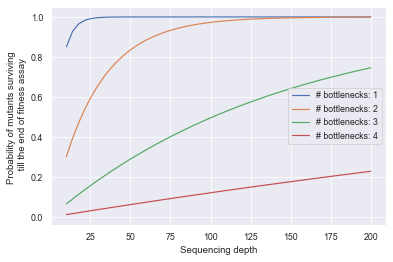

In [53]:
for i in range(len(days_range)-1):
    plt.plot(seq_depth, 1-prob_survival[:,i], label='# bottlenecks: '+str(days_range[i]-1))
    plt.xlabel('Sequencing depth')
    plt.ylabel('Probability of mutants surviving \n till the end of fitness assay')
    plt.legend()

#### Fix sequencing depth (something very high), say 250X: how do error estimates depend on number of bottlenecks for different true fitness effects?


In [172]:
error_days_s = np.zeros([len(s_range), len(n_days)])
for i in range(len(s_range)):
    s = s_range[i]
    for j in range(len(n_days)):
        d = n_days[j]
        trajs = simulate_assay(initial_counts=np.ones(5000)*500, s_mut=s, t=d.astype('int'), gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        error_days_s[i,j] = std